## Description about this notebook
This notebook is designed to visually compare the performance of our three different YOLO NAS models (Small, Medium, Large) in terms of two key metrics: Mean Average Precision at 50% (MAP50) and Mean Average Precision from 50% to 95% (MAP50:95). We employed a supervision function for this evaluation. The assessment was carried out on a test dataset, which was not previously exposed to the models. This test dataset is unique as it comprises a new blend of Jersey and Holstein cow images, captured from two distinct camera perspectives: top and side views. This setup ensures a comprehensive evaluation of the models' ability to accurately detect and recognize objects in varied and realistic scenarios.

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import logging
#####################################
# Set logging level to WARNING to ignore INFO messages
logging.basicConfig(level=logging.WARNING)

import os
os.environ['TORCH_HOME'] = '/home/mautushid/.torch'

#from ultralytics import NAS
os.chdir("..")
ROOT = os.getcwd()
print(ROOT)


/home/mautushid/Cowsformer


In [2]:
from models.nas import *
import pandas as pd
import matplotlib.pyplot as plt

The console stream is logged into /home/mautushid/sg_logs/console.log


[2024-03-02 12:05:42] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-03-02 12:05:42] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-03-02 12:05:45] WARNING - __init__.py - Matplotlib created a temporary cache directory at /localscratch/2183901/matplotlib-zmsmkpjv because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
[2024-03-02 12:05:46] INFO - font_manager.py - generated new fontManager
[2024-03-02 12:05:49] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-03-02 12:05:49] WARNING - export.py - Failed to import pytorch_quantization
[2024-03-02 12:05:49] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [5]:

# Directory containing all the checkpoints
checkpoints_dir = ROOT + "/checkpoints_cow200"

# Function to sort and organize checkpoint paths into the specified format
def organize_checkpoints_corrected(checkpoints_dir):
    # Dictionary to hold the paths categorized by category, then by type
    categorized_paths = {}

    # Iterate through each subdirectory in the checkpoints directory
    for sub_dir in os.listdir(checkpoints_dir):
        # Construct the full path of the subdirectory
        full_sub_dir_path = os.path.join(checkpoints_dir, sub_dir)
        # Check if the current path is a directory
        if os.path.isdir(full_sub_dir_path):
            # Extract category, iteration, and type from the folder name
            parts = sub_dir.split('_')
            category = parts[0]  # e.g., n10
            size_type = parts[-2][-1]  # Assuming type is represented by the last letter before the category and iteration

            # Validate size_type to be 's', 'm', or 'l'
            if size_type not in ['s', 'm', 'l']:
                continue  # Skip if size_type does not match expected values
            
            # Iterate through the RUN_... directory inside the current subdirectory
            for run_dir in os.listdir(full_sub_dir_path):
                run_dir_path = os.path.join(full_sub_dir_path, run_dir)
                if os.path.isdir(run_dir_path):
                    # Construct the path to the ckpt_best.pth file inside the RUN_... directory
                    ckpt_path = os.path.join(run_dir_path, 'ckpt_best.pth')
                    if os.path.exists(ckpt_path):
                        # Initialize the nested dictionaries and lists as needed
                        if category not in categorized_paths:
                            categorized_paths[category] = {'s': [], 'm': [], 'l': []}
                        categorized_paths[category][size_type].append(ckpt_path)

    # Sort paths within each list
    for category in categorized_paths.keys():
        for size_type in categorized_paths[category].keys():
            categorized_paths[category][size_type].sort()

    return categorized_paths

# Call the function and print the organized checkpoint paths
organized_paths = organize_checkpoints_corrected(checkpoints_dir)
for category, types in organized_paths.items():
    print(f"{category}:")
    for size_type, paths in types.items():
        print(f"  {size_type}:")
        for path in paths:
            print(f"    {path}")


n100:
  s:
    /home/mautushid/Cowsformer/checkpoints_cow200/n100_yolo_nas_s_i1/RUN_20240220_144851_614671/ckpt_best.pth
    /home/mautushid/Cowsformer/checkpoints_cow200/n100_yolo_nas_s_i10/RUN_20240223_101944_752675/ckpt_best.pth
    /home/mautushid/Cowsformer/checkpoints_cow200/n100_yolo_nas_s_i11/RUN_20240223_181035_448469/ckpt_best.pth
    /home/mautushid/Cowsformer/checkpoints_cow200/n100_yolo_nas_s_i12/RUN_20240224_031059_303144/ckpt_best.pth
    /home/mautushid/Cowsformer/checkpoints_cow200/n100_yolo_nas_s_i2/RUN_20240220_214105_366767/ckpt_best.pth
    /home/mautushid/Cowsformer/checkpoints_cow200/n100_yolo_nas_s_i3/RUN_20240221_043235_670846/ckpt_best.pth
    /home/mautushid/Cowsformer/checkpoints_cow200/n100_yolo_nas_s_i4/RUN_20240221_110821_704649/ckpt_best.pth
    /home/mautushid/Cowsformer/checkpoints_cow200/n100_yolo_nas_s_i5/RUN_20240221_174510_037487/ckpt_best.pth
    /home/mautushid/Cowsformer/checkpoints_cow200/n100_yolo_nas_s_i6/RUN_20240222_002313_771724/ckpt_best.

In [6]:
n10_s_path = organized_paths['n10']['s']
n10_m_path = organized_paths['n10']['m']
n10_l_path = organized_paths['n10']['l']

n25_s_path = organized_paths['n25']['s']
n25_m_path = organized_paths['n25']['m']
n25_l_path = organized_paths['n25']['l']

n50_s_path = organized_paths['n50']['s']
n50_m_path = organized_paths['n50']['m']
n50_l_path = organized_paths['n50']['l']

n100_s_path = organized_paths['n100']['s']
n100_m_path = organized_paths['n100']['m']
n100_l_path = organized_paths['n100']['l']

n200_s_path = organized_paths['n200']['s']
n200_m_path = organized_paths['n200']['m']
n200_l_path = organized_paths['n200']['l']

In [45]:
print(len(n10_s_path))
print(len(n10_m_path))
print(len(n10_l_path))

print('------------------')

print(len(n25_s_path))
print(len(n25_m_path))
print(len(n25_l_path))

print('------------------')

print(len(n50_s_path))
print(len(n50_m_path))
print(len(n50_l_path))

print('------------------')
print(len(n100_s_path))
print(len(n100_m_path))
print(len(n100_l_path))

print('------------------')
print(len(n200_s_path))
print(len(n200_m_path))
print(len(n200_l_path))



10
10
10
------------------
10
10
10
------------------
10
10
10
------------------
10
10
9
------------------
9
9
9


In [7]:
path_model_s = 'yolo_nas_s'
path_model_m = 'yolo_nas_m'
path_model_l = 'yolo_nas_l'
dir_train = "/home/mautushid/Cowsformer/data/cow200/yolov5/train"
dir_val = "/home/mautushid/Cowsformer/data/cow200/yolov5/val"
dir_test = "/home/mautushid/Cowsformer/data/cow200/yolov5/test"
name_task = "cow200"
data_yaml_path = "/home/mautushid/Cowsformer/data/cow200/yolov5/data.yaml"

def evaluate_models_s(finetuned_model_paths):
    models = []
    evaluation_results = []
    my_nas = Niche_YOLO_NAS(path_model_s, dir_train, dir_val, dir_test, name_task)
    
    # Load models
    for path in finetuned_model_paths:
        model = my_nas.load(path_model_s, path)
        models.append(model)
    
    # Evaluate models
    for model in models:
        metrics = my_nas.get_map_scores(model, data_yaml_path, "test")
        evaluation_results.append(metrics)
    
    return evaluation_results

def evaluate_models_m(finetuned_model_paths):
    models = []
    evaluation_results = []
    my_nas = Niche_YOLO_NAS(path_model_m, dir_train, dir_val, dir_test, name_task)
    
    # Load models
    for path in finetuned_model_paths:
        model = my_nas.load(path_model_m, path)
        models.append(model)
    
    # Evaluate models
    for model in models:
        metrics = my_nas.get_map_scores(model, data_yaml_path, "test")
        evaluation_results.append(metrics)
    
    return evaluation_results

def evaluate_models_l(finetuned_model_paths):
    models = []
    evaluation_results = []
    my_nas = Niche_YOLO_NAS(path_model_l, dir_train, dir_val, dir_test, name_task)
    
    # Load models
    for path in finetuned_model_paths:
        model = my_nas.load(path_model_l, path)
        models.append(model)
    
    # Evaluate models
    for model in models:
        metrics = my_nas.get_map_scores(model, data_yaml_path, "test")
        evaluation_results.append(metrics)
    
    return evaluation_results

In [ ]:
evaluattion_results_n10_s_path = evaluate_models_s(n10_s_path)
#evaluattion_results_n10_m_path = evaluate_models_m(n10_m_path)
#evaluattion_results_n10_l_path = evaluate_models_l(n10_l_path)

[2024-03-02 12:12:26] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-03-02 12:12:27] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s
[2024-03-02 12:12:32] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_cow200/n10_yolo_nas_s_i1/RUN_20240220_112134_766152/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-03-02 12:12:35] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_cow200/n10_yolo_nas_s_i10/RUN_20240223_041406_643003/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-03-02 12:12:37] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_cow200/n10_yolo_nas_s_i11/RUN_20240223_140000_250514/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-03-02 12:12:41] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_cow200/n10_yolo_nas_s_i12/RUN_20240223_221247_827059/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-03-02 12:12:44] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_cow200/n10_yolo_nas_s_i2/RUN_20240220_175706_330524/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-03-02 12:12:48] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_cow200/n10_yolo_nas_s_i3/RUN_20240221_004656_333726/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-03-02 12:12:52] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_cow200/n10_yolo_nas_s_i4/RUN_20240221_073601_993088/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-03-02 12:12:56] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_cow200/n10_yolo_nas_s_i5/RUN_20240221_141549_103204/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-03-02 12:13:00] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_cow200/n10_yolo_nas_s_i6/RUN_20240221_204641_992017/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-03-02 12:13:04] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_cow200/n10_yolo_nas_s_i7/RUN_20240222_033931_347911/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-03-02 12:13:07] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_cow200/n10_yolo_nas_s_i8/RUN_20240222_103812_782932/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-03-02 12:13:12] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_cow200/n10_yolo_nas_s_i9/RUN_20240222_175205_979504/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-03-02 12:13:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:13:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:13:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:13:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:13:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:13:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:13:48] INFO -

[2024-03-02 12:17:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:17:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:17:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:17:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:17:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:18:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:18:16] INFO -

[2024-03-02 12:24:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:24:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:24:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:24:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:25:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:25:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:25:01] INFO -

[2024-03-02 12:28:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:28:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:28:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:28:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:28:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:28:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:29:01] INFO -

[2024-03-02 12:32:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:32:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:32:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:32:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:32:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:32:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:32:06] INFO -

[2024-03-02 12:34:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:34:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:34:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:34:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:34:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:34:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:34:08] INFO -

[2024-03-02 12:38:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:38:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:38:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:38:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:38:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:38:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:38:26] INFO -

[2024-03-02 12:43:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:43:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:43:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:43:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:43:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:44:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:44:18] INFO -

[2024-03-02 12:47:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:47:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:47:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:48:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:48:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:48:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:48:22] INFO -

[2024-03-02 12:49:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:49:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:49:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:49:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:49:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:49:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:49:35] INFO -

[2024-03-02 12:50:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:50:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:50:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:50:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:50:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:50:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-02 12:50:19] INFO -

In [49]:
evaluattion_results_n10_s_path = evaluate_models_s(n10_s_path)
evaluattion_results_n10_m_path = evaluate_models_m(n10_m_path)
evaluattion_results_n10_l_path = evaluate_models_l(n10_l_path)

evaluattion_results_n25_s_path = evaluate_models_s(n25_s_path)
evaluattion_results_n25_m_path = evaluate_models_m(n25_m_path)
evaluattion_results_n25_l_path = evaluate_models_l(n25_l_path)

evaluattion_results_n50_s_path = evaluate_models_s(n50_s_path)
evaluattion_results_n50_m_path = evaluate_models_m(n50_m_path)
evaluattion_results_n50_l_path = evaluate_models_l(n50_l_path)

evaluattion_results_n100_s_path = evaluate_models_s(n100_s_path)
evaluattion_results_n100_m_path = evaluate_models_m(n100_m_path)
evaluattion_results_n100_l_path = evaluate_models_l(n100_l_path)

evaluattion_results_n200_s_path = evaluate_models_s(n200_s_path)
evaluattion_results_n200_m_path = evaluate_models_m(n200_m_path)
evaluattion_results_n200_l_path = evaluate_models_l(n200_l_path)

[2024-02-23 12:48:03] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-02-23 12:48:03] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s
[2024-02-23 12:48:08] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n25_yolo_nas_s_i1/RUN_20240220_122539_052461/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-23 12:48:10] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n25_yolo_nas_s_i10/RUN_20240223_060652_942487/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-23 12:48:13] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n25_yolo_nas_s_i2/RUN_20240220_190705_133917/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-23 12:48:16] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n25_yolo_nas_s_i3/RUN_20240221_015352_078470/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-23 12:48:19] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n25_yolo_nas_s_i4/RUN_20240221_084452_838388/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-23 12:48:21] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n25_yolo_nas_s_i5/RUN_20240221_151855_749485/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-23 12:48:23] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n25_yolo_nas_s_i6/RUN_20240221_215426_533900/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-23 12:48:26] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n25_yolo_nas_s_i7/RUN_20240222_044846_289138/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-23 12:48:28] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n25_yolo_nas_s_i8/RUN_20240222_115532_763704/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-23 12:48:31] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n25_yolo_nas_s_i9/RUN_20240222_192430_728514/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-23 12:48:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:48:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:48:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:48:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:48:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:48:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:48:34] INFO -

[2024-02-23 12:48:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:48:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:48:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:48:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:48:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:48:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:48:46] INFO -

[2024-02-23 12:48:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:48:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:48:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:48:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:48:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:48:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:48:59] INFO -

[2024-02-23 12:49:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:49:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:49:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:49:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:49:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:49:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:49:13] INFO -

[2024-02-23 12:49:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:49:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:49:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:49:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:49:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:49:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:49:30] INFO -

[2024-02-23 12:49:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:49:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:49:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:49:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:49:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:49:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:49:49] INFO -

[2024-02-23 12:50:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:50:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:50:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:50:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:50:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:50:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:50:01] INFO -

[2024-02-23 12:50:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:50:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:50:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:50:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:50:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:50:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:50:18] INFO -

[2024-02-23 12:50:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:50:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:50:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:50:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:50:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:50:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:50:30] INFO -

model yolo_nas_m loaded


[2024-02-23 12:50:51] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n25_yolo_nas_m_i10/RUN_20240223_065323_499302/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-23 12:50:58] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n25_yolo_nas_m_i2/RUN_20240220_191939_578015/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-23 12:51:05] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n25_yolo_nas_m_i3/RUN_20240221_020617_349366/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-23 12:51:11] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n25_yolo_nas_m_i4/RUN_20240221_085712_914794/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-23 12:51:18] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n25_yolo_nas_m_i5/RUN_20240221_153052_027271/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-23 12:51:23] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n25_yolo_nas_m_i6/RUN_20240221_220629_724088/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-23 12:51:28] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n25_yolo_nas_m_i7/RUN_20240222_050159_790075/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-23 12:51:32] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n25_yolo_nas_m_i8/RUN_20240222_121053_038020/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-23 12:51:38] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n25_yolo_nas_m_i9/RUN_20240222_194511_854021/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-23 12:51:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:51:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:51:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:51:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:51:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:51:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:51:43] INFO -

[2024-02-23 12:52:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:52:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:52:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:52:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:52:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:52:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:52:03] INFO -

[2024-02-23 12:52:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:52:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:52:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:52:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:52:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:52:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:52:21] INFO -

[2024-02-23 12:52:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:52:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:52:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:52:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:52:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:52:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:52:40] INFO -

[2024-02-23 12:52:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:52:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:52:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:52:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:52:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:52:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:52:57] INFO -

[2024-02-23 12:53:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:53:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:53:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:53:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:53:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:53:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:53:15] INFO -

[2024-02-23 12:53:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:53:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:53:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:53:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:53:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:53:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:53:35] INFO -

[2024-02-23 12:53:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:53:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:53:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:53:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:53:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:53:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:53:53] INFO -

[2024-02-23 12:54:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:54:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:54:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:54:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:54:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:54:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:54:12] INFO -

model yolo_nas_l loaded


[2024-02-23 12:54:39] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n25_yolo_nas_l_i10/RUN_20240223_073546_631145/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-23 12:54:47] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n25_yolo_nas_l_i2/RUN_20240220_194626_079536/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-23 12:54:53] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n25_yolo_nas_l_i3/RUN_20240221_023441_885000/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-23 12:55:00] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n25_yolo_nas_l_i4/RUN_20240221_092229_763835/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-23 12:55:07] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n25_yolo_nas_l_i5/RUN_20240221_155455_984440/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-23 12:55:14] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n25_yolo_nas_l_i6/RUN_20240221_223123_311413/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-23 12:55:19] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n25_yolo_nas_l_i7/RUN_20240222_053026_169301/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-23 12:55:26] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n25_yolo_nas_l_i8/RUN_20240222_124008_329088/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-23 12:55:33] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n25_yolo_nas_l_i9/RUN_20240222_202144_589469/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-23 12:55:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:55:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:55:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:55:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:55:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:55:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:55:36] INFO -

[2024-02-23 12:55:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:55:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:55:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:55:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:55:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:55:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:55:57] INFO -

[2024-02-23 12:56:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:56:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:56:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:56:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:56:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:56:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:56:28] INFO -

[2024-02-23 12:56:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:56:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:56:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:56:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:56:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:56:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:56:49] INFO -

[2024-02-23 12:57:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:57:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:57:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:57:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:57:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:57:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:57:11] INFO -

[2024-02-23 12:57:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:57:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:57:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:57:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:57:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:57:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:57:32] INFO -

[2024-02-23 12:57:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:57:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:58:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:58:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:58:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:58:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:58:01] INFO -

[2024-02-23 12:58:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:58:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:58:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:58:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:58:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:58:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:58:30] INFO -

[2024-02-23 12:58:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:58:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:58:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:58:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:58:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:58:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 12:58:52] INFO -

model yolo_nas_s loaded


[2024-02-23 13:00:10] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n50_yolo_nas_s_i10/RUN_20240223_081750_483048/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-23 13:00:13] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n50_yolo_nas_s_i2/RUN_20240220_202122_968273/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-23 13:00:17] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n50_yolo_nas_s_i3/RUN_20240221_031008_638856/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-23 13:00:20] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n50_yolo_nas_s_i4/RUN_20240221_095403_253657/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-23 13:00:23] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n50_yolo_nas_s_i5/RUN_20240221_162654_173121/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-23 13:00:25] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n50_yolo_nas_s_i6/RUN_20240221_230544_499013/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-23 13:00:28] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n50_yolo_nas_s_i7/RUN_20240222_060624_625529/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-23 13:00:31] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n50_yolo_nas_s_i8/RUN_20240222_132042_278247/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-23 13:00:33] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n50_yolo_nas_s_i9/RUN_20240222_213259_802746/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-23 13:00:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:00:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:00:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:00:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:00:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:00:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:00:35] INFO -

[2024-02-23 13:00:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:00:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:00:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:00:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:00:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:00:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:00:47] INFO -

[2024-02-23 13:00:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:00:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:00:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:00:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:00:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:00:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:01:00] INFO -

[2024-02-23 13:01:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:01:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:01:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:01:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:01:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:01:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:01:12] INFO -

[2024-02-23 13:01:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:01:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:01:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:01:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:01:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:01:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:01:31] INFO -

[2024-02-23 13:01:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:01:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:01:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:01:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:01:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:01:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:01:43] INFO -

[2024-02-23 13:01:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:01:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:01:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:01:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:01:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:01:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:01:55] INFO -

[2024-02-23 13:02:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:02:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:02:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:02:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:02:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:02:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:02:08] INFO -

[2024-02-23 13:02:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:02:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:02:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:02:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:02:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:02:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:02:20] INFO -

model yolo_nas_m loaded


[2024-02-23 13:02:42] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n50_yolo_nas_m_i10/RUN_20240223_084928_782079/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-23 13:02:47] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n50_yolo_nas_m_i2/RUN_20240220_203508_284667/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-23 13:02:54] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n50_yolo_nas_m_i3/RUN_20240221_032459_942749/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-23 13:03:01] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n50_yolo_nas_m_i4/RUN_20240221_100731_275122/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-23 13:03:07] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n50_yolo_nas_m_i5/RUN_20240221_163952_300695/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-23 13:03:12] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n50_yolo_nas_m_i6/RUN_20240221_232006_337364/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-23 13:03:17] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n50_yolo_nas_m_i7/RUN_20240222_062019_165189/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-23 13:03:21] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n50_yolo_nas_m_i8/RUN_20240222_133543_778650/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-23 13:03:25] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n50_yolo_nas_m_i9/RUN_20240222_215313_098017/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-23 13:03:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:03:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:03:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:03:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:03:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:03:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:03:30] INFO -

[2024-02-23 13:03:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:03:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:03:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:03:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:03:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:03:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:03:51] INFO -

[2024-02-23 13:04:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:04:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:04:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:04:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:04:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:04:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:04:09] INFO -

[2024-02-23 13:04:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:04:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:04:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:04:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:04:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:04:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:04:28] INFO -

[2024-02-23 13:04:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:04:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:04:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:04:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:04:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:04:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:04:46] INFO -

[2024-02-23 13:05:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:05:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:05:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:05:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:05:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:05:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:05:04] INFO -

[2024-02-23 13:05:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:05:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:05:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:05:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:05:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:05:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:05:22] INFO -

[2024-02-23 13:05:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:05:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:05:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:05:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:05:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:05:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:05:40] INFO -

[2024-02-23 13:05:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:05:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:05:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:05:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:05:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:05:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:05:58] INFO -

model yolo_nas_l loaded


[2024-02-23 13:06:24] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n50_yolo_nas_l_i10/RUN_20240223_092424_833506/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-23 13:06:31] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n50_yolo_nas_l_i2/RUN_20240220_210358_028104/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-23 13:06:38] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n50_yolo_nas_l_i3/RUN_20240221_035438_097557/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-23 13:06:45] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n50_yolo_nas_l_i4/RUN_20240221_103342_538835/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-23 13:06:51] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n50_yolo_nas_l_i5/RUN_20240221_170907_384645/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-23 13:06:57] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n50_yolo_nas_l_i6/RUN_20240221_234904_653353/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-23 13:07:02] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n50_yolo_nas_l_i7/RUN_20240222_064852_706262/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-23 13:07:08] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n50_yolo_nas_l_i8/RUN_20240222_140449_805170/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-23 13:07:14] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n50_yolo_nas_l_i9/RUN_20240222_223559_335822/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-23 13:07:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:07:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:07:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:07:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:07:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:07:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:07:17] INFO -

[2024-02-23 13:07:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:07:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:07:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:07:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:07:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:07:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:07:41] INFO -

[2024-02-23 13:08:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:08:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:08:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:08:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:08:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:08:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:08:02] INFO -

[2024-02-23 13:08:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:08:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:08:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:08:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:08:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:08:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:08:23] INFO -

[2024-02-23 13:08:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:08:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:08:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:08:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:08:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:08:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:08:45] INFO -

[2024-02-23 13:09:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:09:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:09:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:09:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:09:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:09:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:09:05] INFO -

[2024-02-23 13:09:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:09:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:09:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:09:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:09:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:09:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:09:32] INFO -

[2024-02-23 13:09:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:09:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:09:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:09:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:09:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:09:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:09:53] INFO -

[2024-02-23 13:10:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:10:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:10:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:10:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:10:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:10:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:10:14] INFO -

model yolo_nas_s loaded


[2024-02-23 13:10:35] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n100_yolo_nas_s_i10/RUN_20240223_101944_752675/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-23 13:10:38] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n100_yolo_nas_s_i2/RUN_20240220_214105_366767/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-23 13:10:41] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n100_yolo_nas_s_i3/RUN_20240221_043235_670846/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-23 13:10:44] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n100_yolo_nas_s_i4/RUN_20240221_110821_704649/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-23 13:10:46] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n100_yolo_nas_s_i5/RUN_20240221_174510_037487/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-23 13:10:48] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n100_yolo_nas_s_i6/RUN_20240222_002313_771724/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-23 13:10:51] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n100_yolo_nas_s_i7/RUN_20240222_072340_334775/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-23 13:10:54] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n100_yolo_nas_s_i8/RUN_20240222_144031_415186/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-23 13:10:56] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n100_yolo_nas_s_i9/RUN_20240222_232629_840066/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-23 13:10:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:10:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:10:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:10:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:10:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:10:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:10:58] INFO -

[2024-02-23 13:11:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:11:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:11:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:11:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:11:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:11:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:11:21] INFO -

[2024-02-23 13:11:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:11:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:11:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:11:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:11:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:11:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:11:37] INFO -

[2024-02-23 13:11:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:11:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:11:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:11:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:11:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:11:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:11:51] INFO -

[2024-02-23 13:12:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:12:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:12:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:12:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:12:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:12:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:12:05] INFO -

[2024-02-23 13:12:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:12:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:12:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:12:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:12:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:12:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:12:26] INFO -

[2024-02-23 13:12:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:12:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:12:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:12:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:12:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:12:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:12:38] INFO -

[2024-02-23 13:12:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:12:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:12:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:12:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:12:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:12:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:12:51] INFO -

[2024-02-23 13:13:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:13:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:13:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:13:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:13:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:13:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:13:03] INFO -

model yolo_nas_m loaded


[2024-02-23 13:13:22] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n100_yolo_nas_m_i10/RUN_20240223_105344_975858/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-23 13:13:29] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n100_yolo_nas_m_i2/RUN_20240220_215708_706659/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-23 13:13:36] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n100_yolo_nas_m_i3/RUN_20240221_044954_301381/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-23 13:13:42] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n100_yolo_nas_m_i4/RUN_20240221_112436_079045/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-23 13:13:47] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n100_yolo_nas_m_i5/RUN_20240221_180145_682630/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-23 13:13:52] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n100_yolo_nas_m_i6/RUN_20240222_003953_578695/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-23 13:13:57] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n100_yolo_nas_m_i7/RUN_20240222_074039_323578/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-23 13:14:01] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n100_yolo_nas_m_i8/RUN_20240222_145845_549304/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-23 13:14:06] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n100_yolo_nas_m_i9/RUN_20240222_235105_863290/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-23 13:14:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:14:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:14:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:14:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:14:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:14:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:14:08] INFO -

[2024-02-23 13:14:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:14:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:14:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:14:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:14:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:14:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:14:30] INFO -

[2024-02-23 13:15:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:15:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:15:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:15:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:15:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:15:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:15:03] INFO -

[2024-02-23 13:15:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:15:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:15:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:15:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:15:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:15:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:15:21] INFO -

[2024-02-23 13:15:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:15:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:15:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:15:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:15:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:15:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:15:44] INFO -

[2024-02-23 13:16:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:16:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:16:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:16:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:16:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:16:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:16:06] INFO -

[2024-02-23 13:16:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:16:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:16:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:16:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:16:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:16:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:16:24] INFO -

[2024-02-23 13:16:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:16:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:16:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:16:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:16:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:16:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:16:42] INFO -

[2024-02-23 13:16:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:16:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:16:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:16:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:16:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:16:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:17:00] INFO -

model yolo_nas_l loaded


[2024-02-23 13:17:29] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n100_yolo_nas_l_i2/RUN_20240220_222724_698637/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-23 13:17:36] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n100_yolo_nas_l_i3/RUN_20240221_052332_098659/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-23 13:17:45] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n100_yolo_nas_l_i4/RUN_20240221_115734_020888/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-23 13:17:51] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n100_yolo_nas_l_i5/RUN_20240221_183221_676666/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-23 13:17:57] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n100_yolo_nas_l_i6/RUN_20240222_010956_521586/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-23 13:18:03] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n100_yolo_nas_l_i7/RUN_20240222_081036_752837/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-23 13:18:09] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n100_yolo_nas_l_i8/RUN_20240222_153130_349340/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-23 13:18:15] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints/n100_yolo_nas_l_i9/RUN_20240223_003610_315832/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-23 13:18:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:18:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:18:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:18:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:18:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:18:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:18:17] INFO -

[2024-02-23 13:18:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:18:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:18:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:18:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:18:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:18:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:18:38] INFO -

[2024-02-23 13:18:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:18:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:18:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:18:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:18:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:18:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:18:59] INFO -

[2024-02-23 13:19:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:19:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:19:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:19:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:19:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:19:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:19:25] INFO -

[2024-02-23 13:19:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:19:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:19:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:19:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:19:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:19:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:19:46] INFO -

[2024-02-23 13:20:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:20:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:20:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:20:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:20:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:20:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:20:06] INFO -

[2024-02-23 13:20:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:20:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:20:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:20:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:20:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:20:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:20:27] INFO -

[2024-02-23 13:20:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:20:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:20:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:20:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:20:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:20:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-23 13:20:49] INFO -

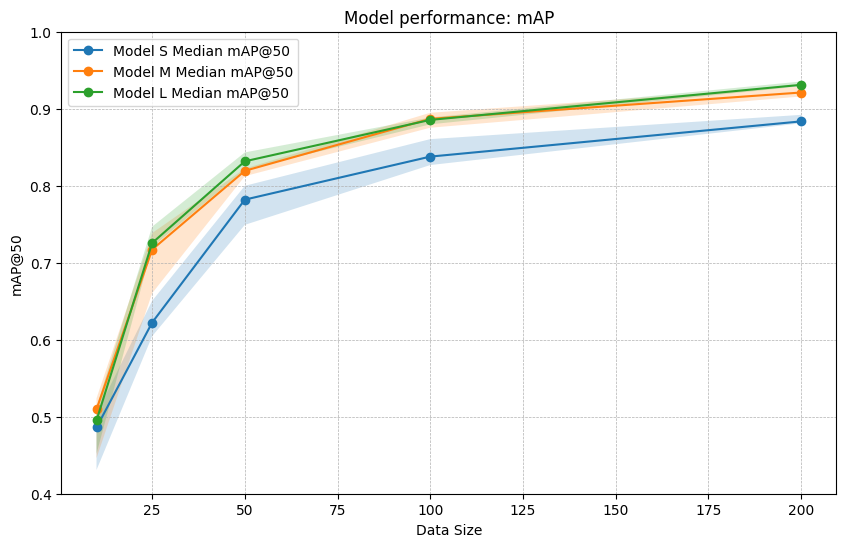

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the actual evaluation data in these variables
# Replace these lines with your actual evaluation data
evaluation_results_n10_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n10_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n10_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n25_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n25_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n25_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n100_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n100_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n100_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n50_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n50_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n50_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n200_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n200_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n200_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]



# Collect all the results in a dictionary for processing
evaluation_results = {
    'n10_s': evaluattion_results_n10_s_path,
    'n10_m': evaluattion_results_n10_m_path,
    'n10_l': evaluattion_results_n10_l_path,
    'n25_s': evaluattion_results_n25_s_path,
    'n25_m': evaluattion_results_n25_m_path,
    'n25_l': evaluattion_results_n25_l_path,
    'n50_s': evaluattion_results_n50_s_path,
    'n50_m': evaluattion_results_n50_m_path,
    'n50_l': evaluattion_results_n50_l_path,
    'n100_s': evaluattion_results_n100_s_path,
    'n100_m': evaluattion_results_n100_m_path,
    'n100_l': evaluattion_results_n100_l_path,
    'n200_s': evaluattion_results_n200_s_path,
    'n200_m': evaluattion_results_n200_m_path,
    'n200_l': evaluattion_results_n200_l_path,
    
}

# Calculate statistics for each combination of dataset size and model complexity
evaluation_statistics = {}
for key, results in evaluation_results.items():
    map50_scores = [res['mAP@50'] for res in results]
    median_map50 = np.median(map50_scores)
    q1_map50 = np.percentile(map50_scores, 25)
    q3_map50 = np.percentile(map50_scores, 75)
    
    evaluation_statistics[key] = {
        'median': median_map50,
        'q1': q1_map50,
        'q3': q3_map50
    }

# Sort the keys to make sure the data sizes are in order (from smallest to largest dataset size)
sorted_keys = sorted(evaluation_statistics, key=lambda x: (int(x[1:x.index('_')]), x[-1]))

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the median values and fill the area between Q1 and Q3
for model_size in ['s', 'm', 'l']:  # For each model size
    data_sizes = [int(key[1:key.index('_')]) for key in sorted_keys if key.endswith(model_size)]
    median_values = [evaluation_statistics[key]['median'] for key in sorted_keys if key.endswith(model_size)]
    q1_values = [evaluation_statistics[key]['q1'] for key in sorted_keys if key.endswith(model_size)]
    q3_values = [evaluation_statistics[key]['q3'] for key in sorted_keys if key.endswith(model_size)]

    # Plot the median line
    ax.plot(data_sizes, median_values, marker='o', label=f'Model {model_size.upper()} Median mAP@50')
    
    # Fill the area between Q1 and Q3 for the interquartile range
    ax.fill_between(data_sizes, q1_values, q3_values, alpha=0.2)

# Customize the plot
ax.set_title('Model performance: mAP')
ax.set_xlabel('Data Size')
ax.set_ylabel('mAP@50')
ax.set_xticks([25, 50, 75, 100, 125, 150, 175, 200]) 
ax.set_ylim(0.4, 1.0)  # Adjust y-axis limits to match your data
ax.legend(loc='upper left', frameon=True)  # Adjust legend to match the example
ax.grid(True, which='major', linestyle='--', linewidth=0.5)  # Adjust grid to be less prominent

# Show the plot
plt.show()